# Model the number of (active) companies at a simplified post-code

In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
import duckdb as ddb

import scipy as sp
import scipy.special as sp_sp

import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm

import datetime as dt
import dateutil as du

Load the company house database

In [2]:
db_name = 'companies_house_data/filtered_combined_data.parquet'
con = ddb.connect()
con.execute(
    f"""
    CREATE TABLE companies_house AS (
        SELECT 
            company_name,
            company_number,
            sic_code,
            company_status,
            address_post_code,
            inc_date,
            REPLACE(SUBSTRING(address_post_code, 1, STRLEN(address_post_code)-2), ' ', '') AS simplified_pc,
            CASE
                WHEN INSTR(UPPER(company_status), 'ACTIVE')>0 THEN 1
                ELSE 0
            END AS active_flag
        FROM "{db_name}"
        WHERE simplified_pc IS NOT NULL
    );
    """
)

Fields preview

In [3]:
con.execute(
    f"""
    SELECT *  FROM companies_house WHERE RANDOM()<0.05 LIMIT 5;
    """
).fetchdf()

,company_name,company_number,sic_code,company_status,address_post_code,inc_date,simplified_pc,active_flag
0,!NVERTD DESIGNS LIMITED,09152972,58190 - Other publishing activities,Active,RH16 4RW,2014-07-30,RH164,1
1,!OBAC LIMITED,FC031362,None Supplied,Active,GY1 1EW,2012-11-30,GY11,1
2,"""BEDE INVESTMENT PROPERTIES LIMITED""",02871100,68100 - Buying and selling of own real estate,Active,W12 8LA,1993-11-12,W128,1
3,"""BSP RETAIL"" LIMITED",10813901,47110 - Retail sale in non-specialised stores ...,Active - Proposal to Strike off,CM0 7TJ,2017-06-12,CM07,1
4,"""CANNON CHAMBERS"" 17 CANNON PLACE MANAGEMENT L...",02076454,74990 - Non-trading company,Active,NW3 1EH,1986-11-21,NW31,1


Check the split of companies between status

In [4]:
con.execute(
    f"""
    SELECT 
        * 
    FROM (
        SELECT
            company_status,
            active_flag,
            COUNT(DISTINCT company_number) AS per_status_count
        FROM companies_house
        GROUP BY company_status, active_flag
    )
    ORDER BY per_status_count DESC
    LIMIT 20;
    """
).fetchdf()

,company_status,active_flag,per_status_count
0,Active,1,5058718
1,Active - Proposal to Strike off,1,376584
2,Liquidation,0,109446
3,In Administration,0,3521
4,Live but Receiver Manager on at least one charge,0,1790
5,Voluntary Arrangement,0,550
6,In Administration/Administrative Receiver,0,301
7,RECEIVERSHIP,0,175
8,ADMINISTRATION ORDER,0,118
9,ADMINISTRATIVE RECEIVER,0,106


Identify simplified post-codes where there are a lot of companies, but also a sizeable portion of no-longer active companies

In [5]:
filtered_spc_df = con.execute(
    f"""
    SELECT 
        * 
    FROM (
        SELECT
            simplified_pc,
            COUNT(DISTINCT CASE WHEN active_flag=1 THEN company_number ELSE NULL END) AS active_company_count,
            COUNT(DISTINCT company_number) AS company_count
        FROM companies_house
        WHERE inc_date > (DATE'1999-12-31')
        GROUP BY simplified_pc
    )
    WHERE 
        active_company_count<0.6*company_count
        AND
        active_company_count>0.5*company_count
        AND
        company_count > 100
    ORDER BY active_company_count DESC
    LIMIT 100000;
    """
).fetchdf()

print(f'Got {len(filtered_spc_df)} records')
filtered_spc_df.head(10)

Got 12 records


,simplified_pc,active_company_count,company_count
0,NN15,1415,2709
1,M24,1134,1989
2,OL11,978,1930
3,N28,914,1645
4,SS93,828,1458
5,M206,811,1397
6,SA14,794,1451
7,DD13,671,1297
8,DN31,313,541
9,NE18,254,482


## Company growth dynamics for a single simplified postcode

Extract the number of companies incorporated in different months

In [6]:
chosen_spc = filtered_spc_df.simplified_pc.iloc[npr.randint(len(filtered_spc_df))]
print(f'Chosen simplified post-code is: {chosen_spc}')

inc_dynamics_df = con.execute(
    f"""
    WITH
    year_month_vw AS (
        SELECT
            *,
            EXTRACT(YEAR FROM inc_date) AS inc_year,
            EXTRACT(MONTH FROM inc_date) AS inc_month
        FROM companies_house
        WHERE 
            simplified_pc='{chosen_spc}' 
            AND inc_date > (DATE'1999-12-31')
    )

    SELECT
        inc_year,
        inc_month,
        (inc_year*12+inc_month) AS abs_inc_month,
        COUNT(DISTINCT company_number) AS company_count,
        COUNT(DISTINCT CASE WHEN active_flag=1 THEN company_number ELSE NULL END) AS active_company_count
    FROM year_month_vw
    GROUP BY inc_year, inc_month
    LIMIT 1000
    ;
    """
).fetchdf().sort_values('abs_inc_month')

print(f'Extracted {len(inc_dynamics_df)} rows')

inc_dynamics_df.head(3)

Chosen simplified post-code is: TR109
Extracted 205 rows


,inc_year,inc_month,abs_inc_month,company_count,active_company_count
50,2000,4,24004,1,1
204,2000,6,24006,1,0
13,2000,12,24012,1,0


Build arrays for easier analysis. It is possible to have months with no companies incorporated. For those the number of incorporated companies is zero

In [7]:
min_abs_inc_month = inc_dynamics_df.abs_inc_month.min()
max_abs_inc_month = inc_dynamics_df.abs_inc_month.max()
min_srs = inc_dynamics_df.query(f'abs_inc_month=={min_abs_inc_month}').iloc[0,:]
min_dt = dt.datetime(year=min_srs.inc_year, month=min_srs.inc_month, day=1)

dt_list = []
dt_str_list = []
company_count_list = []

for abs_inc_month in range(min_abs_inc_month, max_abs_inc_month+1):
    # extract the number of companies incoroporated in this month
    cur_df = inc_dynamics_df.query(f'abs_inc_month=={abs_inc_month}')
    assert len(cur_df) <= 1
    #
    if len(cur_df) == 0:
        inc_company_count = 0
    else:
        inc_company_count = cur_df.company_count.iloc[0]

    # handle dates
    cur_dt = min_dt + du.relativedelta.relativedelta(months= (abs_inc_month - min_abs_inc_month) )
    cur_dt_str = cur_dt.strftime('%Y-%m')

    company_count_list.append(inc_company_count)
    dt_list.append(cur_dt)
    dt_str_list.append(cur_dt_str)

company_count_arr = np.array(company_count_list)

Plot results number of companies incorporated every month

Text(0.5, 1.0, 'Number of companies incorporated at TR109')

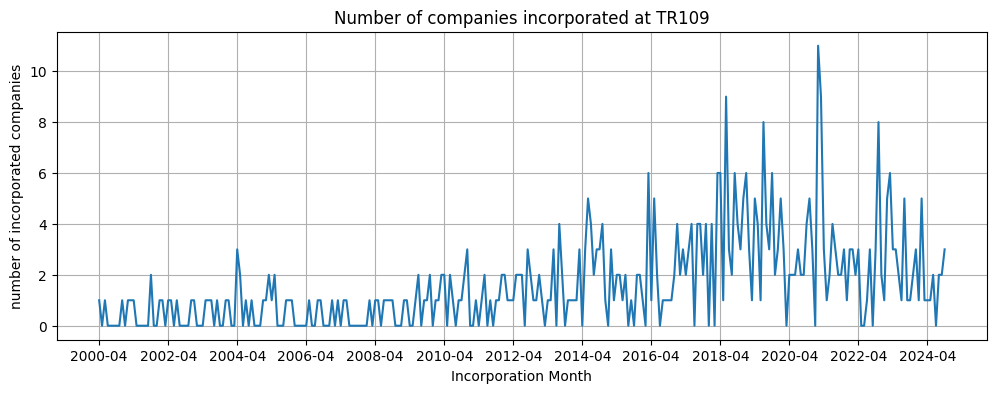

In [8]:

skip_month = 24

fig, ax = pp.subplots(figsize=(12, 4))
ax.plot(np.arange(len(company_count_arr)), company_count_arr)
ax.set_xticks(np.arange(len(company_count_arr))[::skip_month])
ax.set_xticklabels(dt_str_list[::skip_month])
ax.set_xlabel('Incorporation Month')
ax.set_ylabel('number of incorporated companies')
ax.grid()
ax.set_title(f'Number of companies incorporated at {chosen_spc}')

Check that one can approximate Poisson binomial variable with a normal, in this case. First compute the parameters of the normal distribution, then sample from the Poisson binomial variable distirbution

Approx location 347.446; approx scale 8.832


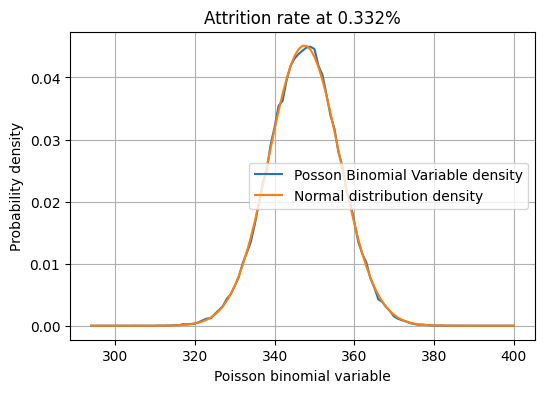

In [9]:
attrition_r = 0.332/100 # assumed attrition rate
# company_count_arr is the number of companies incorporated in
# consequtive months

# compute individual terms in the sum for the approximate distribution
# for debugging, it is useful to keep things separated
loc_sum_arr = np.zeros(len(company_count_arr))
var_sum_arr = np.zeros(len(company_count_arr))
keep_prob_arr = np.zeros(len(company_count_arr))

# go over the months during which the companies were incorporated
# loop in reverse order
for i_month, cur_add in enumerate(company_count_arr[::-1]):
    # probability of keeping the company active
    # (given that it was incroporated in i-th month)
    keep_prob = (1 - attrition_r) ** (i_month)
    
    keep_prob_arr[i_month] = keep_prob
    loc_sum_arr[i_month] = cur_add * keep_prob

    if i_month > 0:
        var_sum_arr[i_month] = cur_add * keep_prob * (1-keep_prob)

#########

approx_loc = np.sum(loc_sum_arr)
approx_var = np.sum(var_sum_arr)
approx_scale = np.sqrt(approx_var) 

print(f'Approx location {approx_loc:.3f}; approx scale {approx_scale:.3f}')


#### sample poisson binomial variable

rng = npr.default_rng()
poibin_sample_count = 100000

poibin_sum_arr = np.zeros(poibin_sample_count, dtype=int)

# sample the from the poisson binomial distribution
for i_sample in range(poibin_sample_count):
    # sample from individual binomial distribution
    cur_sample_arr = rng.binomial(n=company_count_arr[::-1], p=keep_prob_arr)
    poibin_sum_arr[i_sample] = np.sum(cur_sample_arr)

####### plot for comparison

min_edge = int(approx_loc - 6*approx_scale)
max_edge = int(approx_loc + 6*approx_scale)
common_bins = np.array([*(np.arange(min_edge, max_edge+1)-0.5), max_edge+0.5])
bin_mids = (common_bins[1:]+common_bins[:-1])/2
bin_step = common_bins[1]-common_bins[0]

# get the samples from the poisson binomial distribution and split them into bins
# then convert this into density
res_counts = np.histogram(poibin_sum_arr, bins=common_bins)[0]
res_density = (res_counts/np.sum(res_counts))*(1/bin_step)

# get the density of approximating normal distirbution
normal_density = np.exp(-(bin_mids-approx_loc)**2/(2*approx_var))/np.sqrt(2*np.pi*approx_var)

# plot two for comparison
fig, ax = pp.subplots(figsize=(6, 4))
ax.plot(bin_mids, res_density, label='Posson Binomial Variable density')
ax.plot(bin_mids, normal_density, label='Normal distribution density')
ax.set_xlabel('Poisson binomial variable')
ax.set_ylabel('Probability density')
ax.grid()
ax.set_title(f'Attrition rate at {attrition_r*100:.3f}%')
ax.legend()

## Systematic estimation of probability distirbution for the attrtion rate

One can now systematically estimate the attrition rate. In frequentist setting one can use Maximum Likelihood estimation. In Bayesian setting, one can use normal likelihood combined with the prior for the attrition rate. If the prior is assumed to be flat, the two approaches coincide.

MLE: 0.746803%
CI: [0.648481%, 0.862910%]


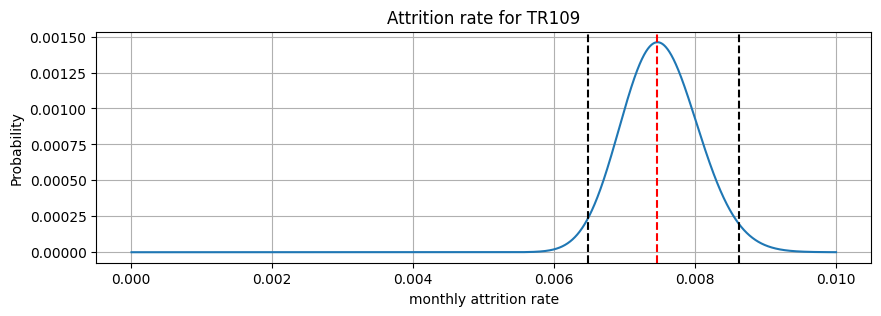

In [10]:
def observation_log_prob(
    attrition_r,
    incorporated_company_count_arr,
    final_active_company_count
):
    month_count = len(incorporated_company_count_arr)
    keep_prob = (1-attrition_r) ** ( (month_count-1) - np.arange(month_count))

    approx_loc = np.sum(incorporated_company_count_arr * keep_prob)
    approx_var = np.sum((1-keep_prob)*keep_prob*incorporated_company_count_arr)

    log_prob = -(1/2)*np.log(2*np.pi*approx_var) - ((final_active_company_count-approx_loc)**2/(2*approx_var))

    return log_prob

#####

# compute log-probabilities for a range of values
attrition_rate_arr = np.linspace(1e-5, 1000e-5, 5000)
log_prob_arr = np.zeros_like(attrition_rate_arr)

for i_r, cur_r in enumerate(attrition_rate_arr):
    log_prob_arr[i_r] = observation_log_prob(
        cur_r,
        company_count_arr,
        inc_dynamics_df.active_company_count.sum()
    )

# normalize and plot result
prob_arr = np.exp(log_prob_arr - sp_sp.logsumexp(log_prob_arr))
mle_attrition_rate = attrition_rate_arr[np.argmax(prob_arr)]

ci_q = 0.05
left_ci = attrition_rate_arr[np.argmin(np.abs(np.cumsum(prob_arr) - ci_q/2))]
right_ci = attrition_rate_arr[np.argmin(np.abs(np.cumsum(prob_arr) - (1-ci_q/2)))]

fig, ax = pp.subplots(figsize=(10, 3))
ax.plot(attrition_rate_arr, prob_arr)
ax.axvline(mle_attrition_rate, color='r', linestyle='--')
ax.axvline(left_ci, color='k', linestyle='--')
ax.axvline(right_ci, color='k', linestyle='--')
ax.grid()
ax.set_xlabel('monthly attrition rate')
ax.set_ylabel('Probability')
ax.set_title(f'Attrition rate for {chosen_spc}')
#ax.set_xlim([0, 2*mle_attrition_rate])

print(f'MLE: {mle_attrition_rate*100:.6f}%')
print(f'CI: [{left_ci*100:.6f}%, {right_ci*100:.6f}%]')


In [11]:
filtered_spc_df.query(f'simplified_pc=="{chosen_spc}"')

,simplified_pc,active_company_count,company_count
10,TR109,254,467


In [12]:
cur_df = filtered_spc_df.query(f'simplified_pc=="{chosen_spc}"')
1-(cur_df.active_company_count/cur_df.company_count).values

array([0.45610278])

In [14]:
np.mean([
    0.695044, 0.746803, 0.830736, 0.655476, 0.695044,
    0.777978, 0.695044, 0.777978, 0.644285, 0.746803
    
])

np.float64(0.7265191)

In [17]:
1-0.85**(1/(12*24))

0.0005641426501963309